In [28]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_excel('e-commerce-data.xlsx')
df.head()

,UserId,UserCity,ItemCategory,ItemName,ItemPrice,ItemQuantity,TotalPaid,PurchaseDate,DeliveryDate,ItemWeight,PromoCode_Used
0,548,San Diego,Fashion,Shoes,474,9,4266.0,2024-09-14 09:21:50.271,2024-09-20 09:21:50.271,8.638593,False
1,907,Philadelphia,Toys,Game,385,5,1925.0,2024-09-01 09:21:50.271,2024-09-03 09:21:50.271,NaN,False
2,282,San Antonio,Sports,Bat,382,9,3438.0,2024-08-23 09:21:50.271,2024-08-30 09:21:50.271,3.894490,False
3,445,Philadelphia,Electronics,Watch,628,8,5024.0,2024-09-06 09:21:50.271,2024-09-16 09:21:50.271,9.786269,False
4,178,Philadelphia,Sports,Gym Equipment,788,5,3940.0,2024-09-10 09:21:50.271,2024-09-14 09:21:50.271,6.225748,True


In [30]:
df.shape

(1000, 11)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   UserId          1000 non-null   int64         
 1   UserCity        970 non-null    object        
 2   ItemCategory    970 non-null    object        
 3   ItemName        1000 non-null   object        
 4   ItemPrice       1000 non-null   int64         
 5   ItemQuantity    1000 non-null   int64         
 6   TotalPaid       930 non-null    float64       
 7   PurchaseDate    1000 non-null   datetime64[ns]
 8   DeliveryDate    960 non-null    datetime64[ns]
 9   ItemWeight      750 non-null    float64       
 10  PromoCode_Used  1000 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 79.2+ KB


In [32]:
df.isna().sum()

UserId              0
UserCity           30
ItemCategory       30
ItemName            0
ItemPrice           0
ItemQuantity        0
TotalPaid          70
PurchaseDate        0
DeliveryDate       40
ItemWeight        250
PromoCode_Used      0
dtype: int64

## TotalPaid

In [33]:
df['TotalPaid'] = np.where(df['TotalPaid'].isnull(), df['ItemPrice']*df['ItemQuantity'], df['TotalPaid'])

## ItemWeight

Text(0.5, 1.0, 'Distribution of ItemWeight')

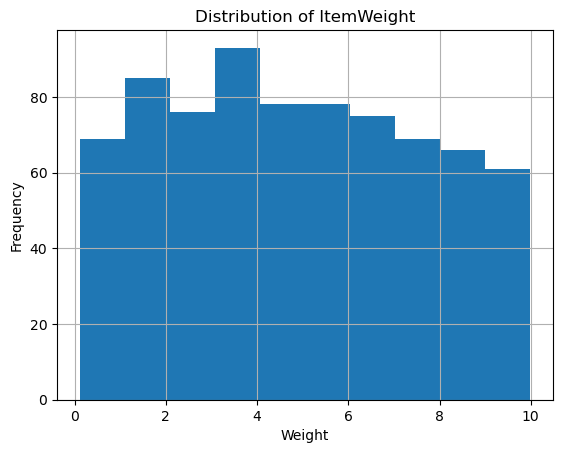

In [34]:
df['ItemWeight'].hist()

plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of ItemWeight')

In [35]:
df['ItemWeight'] = df['ItemWeight'].fillna(df['ItemWeight'].median())

In [36]:
df.isna().sum()

UserId             0
UserCity          30
ItemCategory      30
ItemName           0
ItemPrice          0
ItemQuantity       0
TotalPaid          0
PurchaseDate       0
DeliveryDate      40
ItemWeight         0
PromoCode_Used     0
dtype: int64

## ItemCategory

In [37]:
df['ItemCategory'].value_counts()

ItemCategory
Electronics    177
Grocery        142
Sports         140
Toys           139
Fashion        137
Beauty         125
Home Goods     110
Name: count, dtype: int64

In [38]:
df['ItemName'] = df['ItemName'].replace({'phone': 'Phone',
                                        'GymEquipment': 'Gym Equipment',
                                        'Headphone': 'Headphones'})

In [18]:
# Approach 1
category_keywords = {
    "Electronics": ["Laptop", "Phone", "Tablet", "TV", "Watch", "Headphones", "Speaker"],
    "Fashion": ["Shirt", "Pants", "Dress", "Shoes", "Hat", "Accessory"],
    "Home Goods": ["Sofa", "Table", "Bed", "Kitchenware", "Decor"],
    "Toys": ["Doll", "Game", "Puzzle", "Lego", "Action Figure"],
    "Sports": ["Ball", "Bat", "Racket", "Bike", "Gym Equipment"],
    "Beauty": ["Makeup", "Skincare", "Haircare", "Perfume", "Nail Polish"],
    "Grocery": ["Food", "Beverages", "Snacks", "Household Supplies"]
}

def find_category(item_name):
    for category, keywords in category_keywords.items():
        if any(keyword in item_name for keyword in keywords):
            return category
    return np.nan

df['ItemCategory'] = df['ItemCategory'].fillna(df['ItemName'].apply(find_category))

In [39]:
# Approach 2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['ItemName'].fillna(''))

df_non_null = df.dropna(subset=['ItemCategory'])

X_train = vectorizer.transform(df_non_null['ItemName'])
y_train = df_non_null['ItemCategory']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
missing_categories = df['ItemCategory'].isna()
X_missing = vectorizer.transform(df[missing_categories]['ItemName'])
df.loc[missing_categories, 'ItemCategory'] = clf.predict(X_missing)

In [41]:
df.isna().sum()

UserId             0
UserCity          30
ItemCategory       0
ItemName           0
ItemPrice          0
ItemQuantity       0
TotalPaid          0
PurchaseDate       0
DeliveryDate      40
ItemWeight         0
PromoCode_Used     0
dtype: int64

## UserCity

In [42]:
# Approach 1: Random Sampling
city_dist = df['UserCity'].value_counts(normalize=True)

missing_values = df['UserCity'].isna()
df.loc[missing_values, 'UserCity'] = np.random.choice(city_dist.index, size=missing_values.sum(), p=city_dist.values)

UserCity
Dallas          108
San Diego       106
Phoenix         102
Chicago         100
Houston          99
Los Angeles      96
San Antonio      91
Philadelphia     90
Austin           89
New York         89
Name: count, dtype: int64

In [ ]:
# Approach 2: leave missing values as NaN

## DeliveryDate

In [45]:
df['DeliveryTime'] = (df['DeliveryDate']-df['PurchaseDate']).dt.days

<AxesSubplot:>

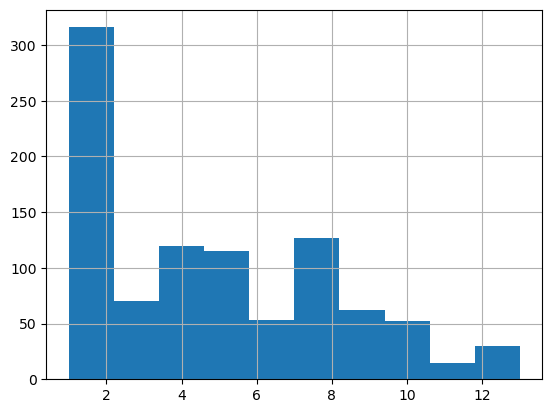

In [46]:
df['DeliveryTime'].hist()

In [47]:
avg_del_time = df['DeliveryTime'].median()

df.loc[df['DeliveryDate'].isna(), 'DeliveryDate'] = df['PurchaseDate'] + pd.to_timedelta(avg_del_time, unit='days')

In [48]:
df.isna().sum()

UserId             0
UserCity          30
ItemCategory       0
ItemName           0
ItemPrice          0
ItemQuantity       0
TotalPaid          0
PurchaseDate       0
DeliveryDate       0
ItemWeight         0
PromoCode_Used     0
DeliveryTime      40
dtype: int64

In [49]:
df

,UserId,UserCity,ItemCategory,ItemName,ItemPrice,ItemQuantity,TotalPaid,PurchaseDate,DeliveryDate,ItemWeight,PromoCode_Used,DeliveryTime
0,548,San Diego,Fashion,Shoes,474,9,4266.0,2024-09-14 09:21:50.271,2024-09-20 09:21:50.271,8.638593,False,6.0
1,907,Philadelphia,Toys,Game,385,5,1925.0,2024-09-01 09:21:50.271,2024-09-03 09:21:50.271,4.681075,False,2.0
2,282,San Antonio,Sports,Bat,382,9,3438.0,2024-08-23 09:21:50.271,2024-08-30 09:21:50.271,3.894490,False,7.0
3,445,Philadelphia,Electronics,Watch,628,8,5024.0,2024-09-06 09:21:50.271,2024-09-16 09:21:50.271,9.786269,False,10.0
4,178,Philadelphia,Sports,Gym Equipment,788,5,3940.0,2024-09-10 09:21:50.271,2024-09-14 09:21:50.271,6.225748,True,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,165,Chicago,Toys,Lego,151,8,1208.0,2024-08-31 09:21:50.271,2024-09-04 09:21:50.271,2.794625,False,4.0
996,305,Phoenix,Fashion,Pants,350,4,1400.0,2024-09-16 09:21:50.271,2024-09-18 09:21:50.271,1.802707,True,2.0
997,734,Austin,Grocery,Beverages,258,1,258.0,2024-09-11 09:21:50.271,2024-09-13 09:21:50.271,4.681075,True,2.0
998,944,Dallas,Fashion,Pants,646,6,3876.0,2024-09-11 09:21:50.271,2024-09-15 09:21:50.271,7.604176,False,NaN


In [51]:
df['ItemWeight'] = df['ItemWeight'].round()
df['Total_ItemWeight'] = df['ItemQuantity']*df['ItemWeight']

In [52]:
df

,UserId,UserCity,ItemCategory,ItemName,ItemPrice,ItemQuantity,TotalPaid,PurchaseDate,DeliveryDate,ItemWeight,PromoCode_Used,DeliveryTime,Total_ItemWeight
0,548,San Diego,Fashion,Shoes,474,9,4266.0,2024-09-14 09:21:50.271,2024-09-20 09:21:50.271,9.0,False,6.0,81.0
1,907,Philadelphia,Toys,Game,385,5,1925.0,2024-09-01 09:21:50.271,2024-09-03 09:21:50.271,5.0,False,2.0,25.0
2,282,San Antonio,Sports,Bat,382,9,3438.0,2024-08-23 09:21:50.271,2024-08-30 09:21:50.271,4.0,False,7.0,36.0
3,445,Philadelphia,Electronics,Watch,628,8,5024.0,2024-09-06 09:21:50.271,2024-09-16 09:21:50.271,10.0,False,10.0,80.0
4,178,Philadelphia,Sports,Gym Equipment,788,5,3940.0,2024-09-10 09:21:50.271,2024-09-14 09:21:50.271,6.0,True,4.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,165,Chicago,Toys,Lego,151,8,1208.0,2024-08-31 09:21:50.271,2024-09-04 09:21:50.271,3.0,False,4.0,24.0
996,305,Phoenix,Fashion,Pants,350,4,1400.0,2024-09-16 09:21:50.271,2024-09-18 09:21:50.271,2.0,True,2.0,8.0
997,734,Austin,Grocery,Beverages,258,1,258.0,2024-09-11 09:21:50.271,2024-09-13 09:21:50.271,5.0,True,2.0,5.0
998,944,Dallas,Fashion,Pants,646,6,3876.0,2024-09-11 09:21:50.271,2024-09-15 09:21:50.271,8.0,False,NaN,48.0


In [53]:
df.to_csv('e-commerce-clean.csv', index=False)